In [112]:
import pandas as pd
from tqdm import tqdm

In [113]:
import random

def random_model(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["logit_0"] = pd.Series([random.uniform(-1, 1) for _ in range(len(df))])
    df["logit_1"] = pd.Series([random.uniform(-1, 1) for _ in range(len(df))])
    return df

In [114]:
df = pd.read_pickle("../results/predictions_abraham_narrnest.pkl")
# df = random_model(df)
print(len(df))
df.head()

79


,book_path,chapter_idx,paragraph_idx,labels,logit_0,logit_1
0,abraham_narrnest.json,0,1,1,1.965182,-1.326698
1,abraham_narrnest.json,0,2,1,5.356499,-3.036992
2,abraham_narrnest.json,1,0,0,4.740864,-2.676311
3,abraham_narrnest.json,1,1,1,-0.311949,0.235681
4,abraham_narrnest.json,1,2,1,1.141951,-0.912189


In [115]:
predicted_chapter_counts = pd.read_pickle("../test_predicted_chapter_counts.pkl")
print(predicted_chapter_counts.head())

                book_path  chapter_count  metrics_prediction  \
0     about_bergkoen.json             10           23.586574   
1     about_parisehe.json             13           20.850396   
2     abraham_fabeln.json              5            9.046316   
3   abraham_narrnest.json             12           11.883909   
4  achleitn_bezirks1.json              5           16.067736   

   novel_metrics_prediction  confidences_prediction  \
0                 20.575634               19.278949   
1                 18.902229               17.377221   
2                  7.265612                8.695430   
3                  9.902353               13.220007   
4                 14.465906               13.105857   

   novel_confidences_prediction  
0                     18.040357  
1                     16.139760  
2                      5.574391  
3                     10.686268  
4                     11.295539  


In [116]:
stats_df = pd.read_pickle("../per_chapter_test_split_stats.pkl")
print(stats_df.head())

   paragraph_count  word_count  sentence_count               book_path  \
0             1059       70700            4205     about_bergkoen.json   
0             1287       64018            3178     about_parisehe.json   
0               15        1011              36     abraham_fabeln.json   
0               80       13506             391   abraham_narrnest.json   
0             1171       42926            2548  achleitn_bezirks1.json   

   chapter_count  
0             10  
0             13  
0              5  
0             12  
0              5  


In [117]:
def predict_top_n(logit_0: pd.Series, break_count):
    threshold_value = logit_0.sort_values(ascending=False).values[min(round(break_count), len(logit_0) - 1)]
    return [l <= threshold_value for l in logit_0.values]

def add_predictions(df: pd.DataFrame) -> pd.DataFrame:
    predicted_chapter_counts = pd.read_pickle("../test_predicted_chapter_counts.pkl")

    books = []
    for book_path, group in df.groupby(["book_path"]):
        local_predictions = group["logit_0"] < group["logit_1"]
        normalized = (group["logit_0"] - group["logit_0"].min())/(group["logit_0"].max() - group["logit_0"].min())
        local_threshold_predictions = [l <= 0.9 for l in normalized]
        gt_chapter_break_count = group["chapter_idx"].max()

        new_df = group.reset_index()
        new_df["local_prediction"] = local_predictions.values
        new_df["local_threshold_prediction"] = local_threshold_predictions
        new_df["top_n_prediction"] = predict_top_n(group["logit_0"], gt_chapter_break_count)

        pred = predicted_chapter_counts[predicted_chapter_counts["book_path"] == book_path]
        if len(pred) > 0:
            metrics = pred["metrics_prediction"].values[0]
            metrics_novel = pred["novel_metrics_prediction"].values[0]
            confidences = pred["confidences_prediction"].values[0]
            confidences_novel = pred["novel_confidences_prediction"].values[0]

            new_df["metrics_prediction"] = predict_top_n(group["logit_0"], metrics)
            new_df["metrics_novel_prediction"] = predict_top_n(group["logit_0"], metrics_novel)
            new_df["confidences_prediction"] = predict_top_n(group["logit_0"], confidences)
            new_df["confidences_novel_prediction"] = predict_top_n(group["logit_0"], confidences_novel)
        else:
            print(book_path)
        books.append(new_df)

    return pd.concat(books)

pred_df = add_predictions(df)
pred_df.head()

,index,book_path,chapter_idx,paragraph_idx,labels,logit_0,logit_1,local_prediction,local_threshold_prediction,top_n_prediction,metrics_prediction,metrics_novel_prediction,confidences_prediction,confidences_novel_prediction
0,0,abraham_narrnest.json,0,1,1,1.965182,-1.326698,False,True,True,True,True,True,True
1,1,abraham_narrnest.json,0,2,1,5.356499,-3.036992,False,False,False,False,False,False,False
2,2,abraham_narrnest.json,1,0,0,4.740864,-2.676311,False,False,False,False,False,False,False
3,3,abraham_narrnest.json,1,1,1,-0.311949,0.235681,True,True,True,True,True,True,True
4,4,abraham_narrnest.json,1,2,1,1.141951,-0.912189,False,True,True,True,True,True,True


In [118]:
import json
from sklearn.metrics import f1_score
from nltk.metrics import segmentation

def calc_f1_score(df: pd.DataFrame, prediction_column: str) -> float:
    # class 0 (chapter break) is relevant for us
    return f1_score(
        df["labels"].replace([1, 0], value=[False, True]),
        df[prediction_column].replace([True, False], value=[False, True]),
    )


def calc_pk_wd(df: pd.DataFrame, prediction_column: str) -> tuple:
    # class 0 (no continuation) should denote chapter break, metrics assume 1
    labels = df["labels"].replace([1, 0], value=[0, 1])
    predictions = df[prediction_column].replace([True, False], value=[0, 1])
    labels = "".join(map(str, labels))
    predictions = "".join(map(str, predictions))
    # k should be half average reference segment length
    # average paragraph count per chapter is ~54
    # median is 32
    k = int(round(len(labels) / (labels.count("1") * 2.0)))
    pk = segmentation.pk(labels, predictions, k=k)
    windowdiff = segmentation.windowdiff(labels, predictions, k=k)
    return pk, windowdiff

def calculate_metrics(df: pd.DataFrame, prediction_column: str) -> pd.DataFrame:
    results = []
    for book, group in tqdm(df.groupby(["book_path"])):
        f1 = calc_f1_score(group, prediction_column)
        pk, windowdiff = calc_pk_wd(group, prediction_column)
        with open(f"../corpus/{book}", "r") as f:
            genre = json.load(f)["genre"]
        results.append({"book": book, "f1": f1, "pk": pk, "wd": windowdiff, "genre": genre})
    return pd.DataFrame(results)

In [119]:
top_n_df = calculate_metrics(pred_df, "top_n_prediction")

print("Micro-averaged F1: ", top_n_df["f1"].mean())
print("Micro-averaged PK: ", top_n_df["pk"].mean())
print("Micro-averaged WD: ", top_n_df["wd"].mean())

100%|██████████| 1/1 [00:00<00:00, 266.86it/s]

Micro-averaged F1:  0.18181818181818182
Micro-averaged PK:  0.40789473684210525
Micro-averaged WD:  0.5131578947368421


In [120]:
genre_grouped = top_n_df.groupby(["genre"])
f1 = genre_grouped["f1"].mean()
pk = genre_grouped["pk"].mean()
wd = genre_grouped["wd"].mean()
count = genre_grouped["book"].count()
result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
result.sort_values(by="f1", ascending=False)

,f1,pk,wd,count
genre,,,,
"Humor, Satire",0.181818,0.407895,0.513158,1


In [121]:
local_df = calculate_metrics(pred_df, "local_prediction")

print("Micro-averaged F1: ", local_df["f1"].mean())
print("Micro-averaged PK: ", local_df["pk"].mean())
print("Micro-averaged WD: ", local_df["wd"].mean())

100%|██████████| 1/1 [00:00<00:00, 270.62it/s]

Micro-averaged F1:  0.3571428571428571
Micro-averaged PK:  0.40789473684210525
Micro-averaged WD:  0.9473684210526315


In [122]:
genre_grouped = local_df.groupby(["genre"])
f1 = genre_grouped["f1"].mean()
pk = genre_grouped["pk"].mean()
wd = genre_grouped["wd"].mean()
count = genre_grouped["book"].count()
result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
result.sort_values(by="count", ascending=False)

,f1,pk,wd,count
genre,,,,
"Humor, Satire",0.357143,0.407895,0.947368,1


In [123]:
local_threshold_df = calculate_metrics(pred_df, "local_threshold_prediction")

print("Micro-averaged F1: ", local_threshold_df["f1"].mean())
print("Micro-averaged PK: ", local_threshold_df["pk"].mean())
print("Micro-averaged WD: ", local_threshold_df["wd"].mean())

100%|██████████| 1/1 [00:00<00:00, 185.81it/s]

Micro-averaged F1:  0.1904761904761905
Micro-averaged PK:  0.39473684210526316
Micro-averaged WD:  0.5


In [124]:
genre_grouped = local_threshold_df.groupby(["genre"])
f1 = genre_grouped["f1"].mean()
pk = genre_grouped["pk"].mean()
wd = genre_grouped["wd"].mean()
count = genre_grouped["book"].count()
result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
result.sort_values(by="count", ascending=False)

,f1,pk,wd,count
genre,,,,
"Humor, Satire",0.190476,0.394737,0.5,1


In [125]:
# metrics_prediction	metrics_novel_prediction	confidences_prediction	confidences_novel_prediction
# temp_pred_df = calculate_metrics(pred_df, "confidences_novel_prediction")

# print("Micro-averaged F1: ", temp_pred_df["f1"].mean())
# print("Micro-averaged PK: ", temp_pred_df["pk"].mean())
# print("Micro-averaged WD: ", temp_pred_df["wd"].mean())

# genre_grouped = temp_pred_df.groupby(["genre"])
# f1 = genre_grouped["f1"].mean()
# pk = genre_grouped["pk"].mean()
# wd = genre_grouped["wd"].mean()
# count = genre_grouped["book"].count()
# result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
# result.sort_values(by="count", ascending=False)

In [126]:
import matplotlib.pyplot as plt
import math
import numpy as np

def plot_book(dataframe: pd.DataFrame, book_id=None, fig_size=(20, 5), column="top_n_prediction"):
    f = open("output_file.txt", "w")
    book_id = book_id
    if book_id == None:
        book_id = random.choice(dataframe["book_path"])
    f.write(book_id + "\n")
    f.write(column + "\n")
    book_df = dataframe[dataframe["book_path"] == book_id]
    book_df.index = [i - min(book_df.index) for i in book_df.index]

    if column == "log_prediction":
        normalized_logit_0 = (book_df["logit_0"] - book_df["logit_0"].min())/(book_df["logit_0"].max() - book_df["logit_0"].min())
        indices = np.where(np.array(normalized_logit_0) > 0.9)[0]
        candidates = book_df.iloc[indices]
    else:
      candidates = book_df[book_df[column] == False]

    plt.figure(figsize=fig_size)
    plt.title(f"BERT-predicted chapter breaks - {book_id}")
    plt.xlabel("Paragraph")
    plt.ylabel("BERT confidence score")
    if column == "log_prediction":
        plt.scatter(book_df.index, normalized_logit_0, s=5)
        plt.scatter(candidates.index, np.array(normalized_logit_0)[indices], c="red", marker="s")
    else:
        plt.scatter(book_df.index, book_df["logit_0"], s=5)
        plt.scatter(candidates.index, candidates["logit_0"], c="red", marker="s")
    f.write("Confidences\n")
    f.write("X\n")
    f.writelines([str(v) + "\n" for v in book_df.index])
    f.write("Y\n")
    f.writelines([str(v) + "\n" for v in book_df["logit_0"]])
    f.write("Candidates\n")
    f.write("X\n")
    f.writelines([str(v) + "\n" for v in candidates.index])
    f.write("Y\n")
    f.writelines([str(v) + "\n" for v in candidates["logit_0"]])
    xcoords = book_df[book_df["labels"] == 0].index
    f.write("Breaks\n")
    f.write("X\n")
    f.writelines([str(v) + "\n" for v in xcoords])
    for x in xcoords:
        plt.axvline(x, c="green")
    f.close()
    plt.show()

In [127]:
# test_df = pd.read_csv("../test_per_book_df.csv")

In [128]:
def top_n_paragraphs(df, book_path, test_df, tokenizer):
    book_df = df.groupby(["book_path"]).get_group(book_path)
    test_df = test_df.groupby(["book_path"]).get_group(book_path)
    candidates = book_df[book_df["top_n_prediction"] == False]
    for idx, candidate in candidates.iterrows():
        test_row = test_df.iloc[idx]
        p1_tokens = json.loads(test_row["p1_tokens"])
        p2_tokens = json.loads(test_row["p2_tokens"])
        print(tokenizer.decode(p1_tokens))
        print("-----------")
        print(tokenizer.decode(p2_tokens))
        print("continuation:", test_row["is_continuation"])
        print("prediction: break")
        print("-----------")

    true_breaks = test_df[test_df["is_continuation"] == False]
    for index, row in true_breaks.iterrows():
        p1_tokens = json.loads(row["p1_tokens"])
        p2_tokens = json.loads(row["p2_tokens"])
        print(tokenizer.decode(p1_tokens))
        print("-----------")
        print(tokenizer.decode(p2_tokens))
        print("continuation:", test_row["is_continuation"])
        print("prediction:", book_df[book_df["index"] == index]["top_n_prediction"])
        print("-----------")

    lowest_score = book_df.loc[book_df['logit_0'].idxmin()]
    print(lowest_score["index"])
    test_row = test_df.loc[lowest_score["index"]]
    p1_tokens = json.loads(test_row["p1_tokens"])
    p2_tokens = json.loads(test_row["p2_tokens"])
    print(tokenizer.decode(p1_tokens))
    print("-----------")
    print(tokenizer.decode(p2_tokens))
    print("continuation:", test_row["is_continuation"])
    print("prediction: break")
    print("-----------")


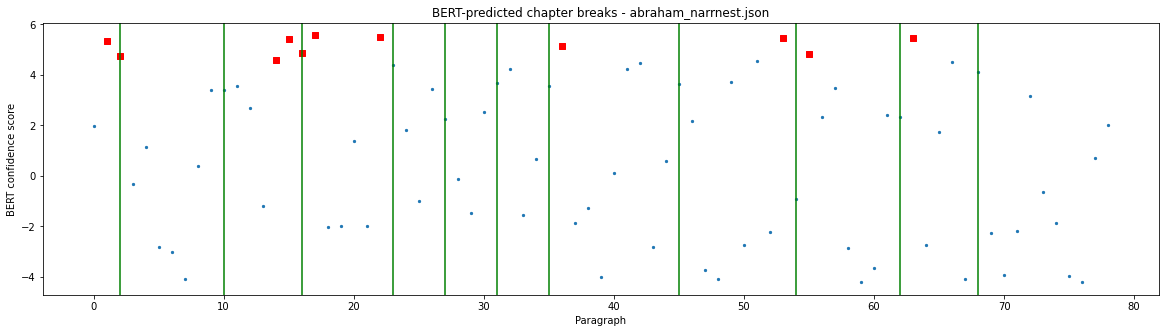

In [129]:
plot_book(pred_df, "abraham_narrnest.json", column="top_n_prediction")

In [130]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("deepset/gbert-base")
top_n_paragraphs(pred_df, "may_baerenj.json", test_df, tokenizer)

KeyError: 'may_baerenj.json'

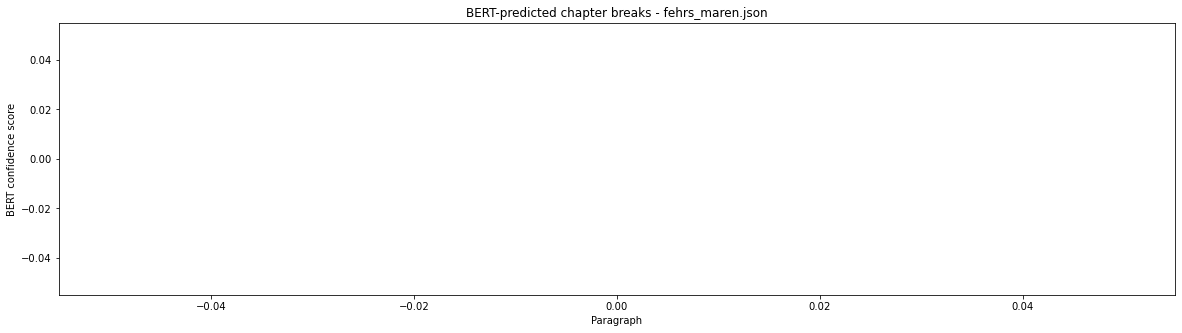

In [ ]:
plot_book(pred_df, "fehrs_maren.json", column="top_n_prediction")

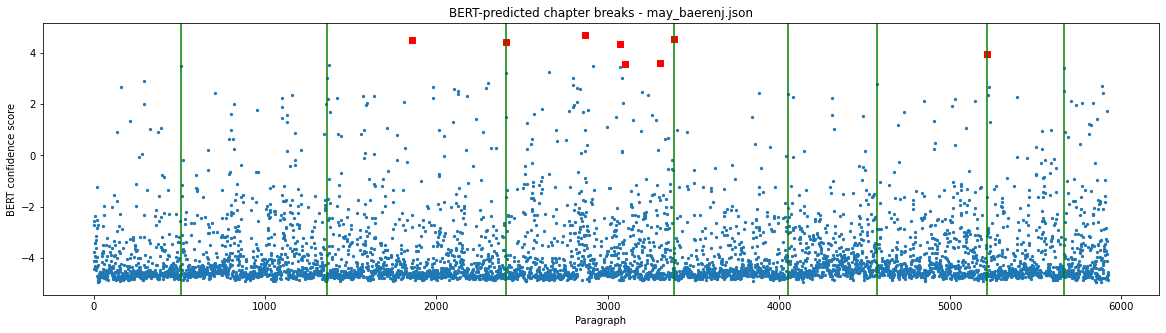

In [ ]:
# potentially interesting examples:
# * margot_apachen1.json (perfect prediction)
# * may_baerenj.json (clustered predictions with peaks on chapter breaks)
# * lagerloe_christus.json (anthology w/ some multi-chapter stories inside)
plot_book(pred_df, "may_baerenj.json", column="top_n_prediction")

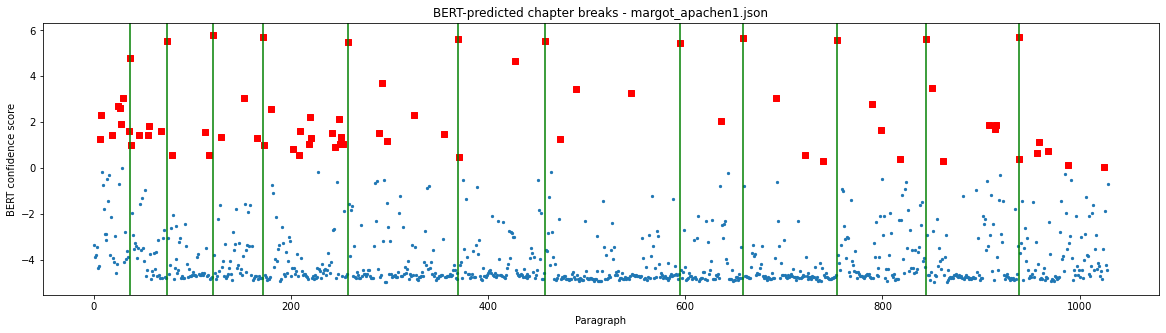

In [ ]:
plot_book(pred_df, "margot_apachen1.json", column="local_prediction")

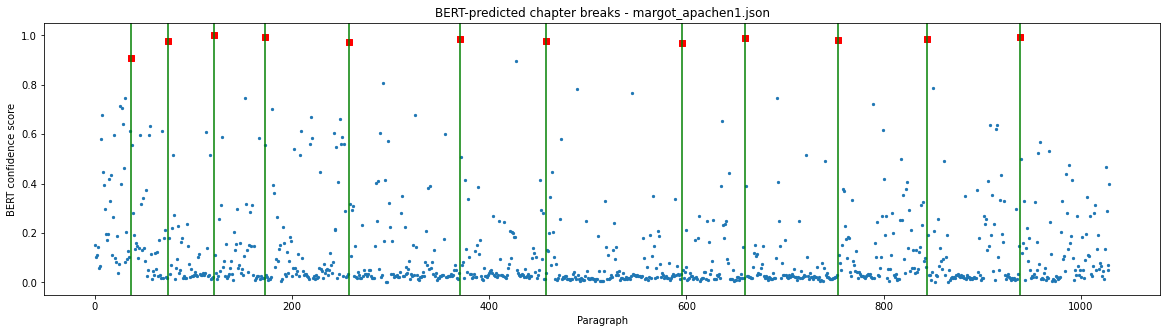

In [ ]:
plot_book(pred_df, "margot_apachen1.json", column="log_prediction")

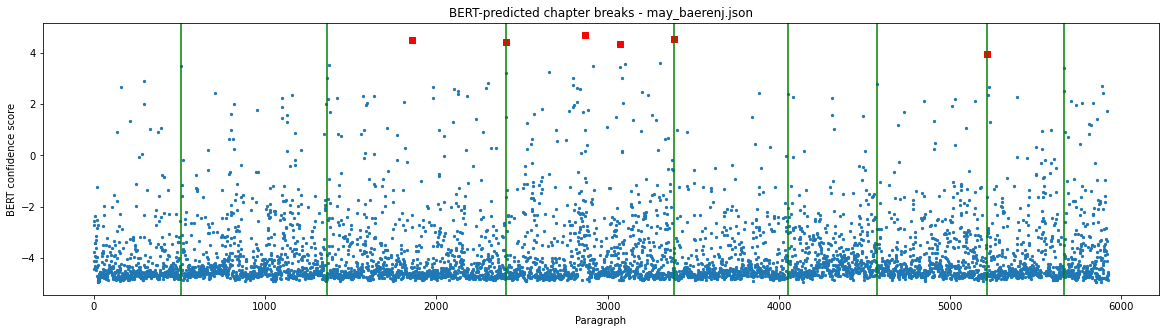

In [ ]:
plot_book(pred_df, "may_baerenj.json", column="local_threshold_prediction")

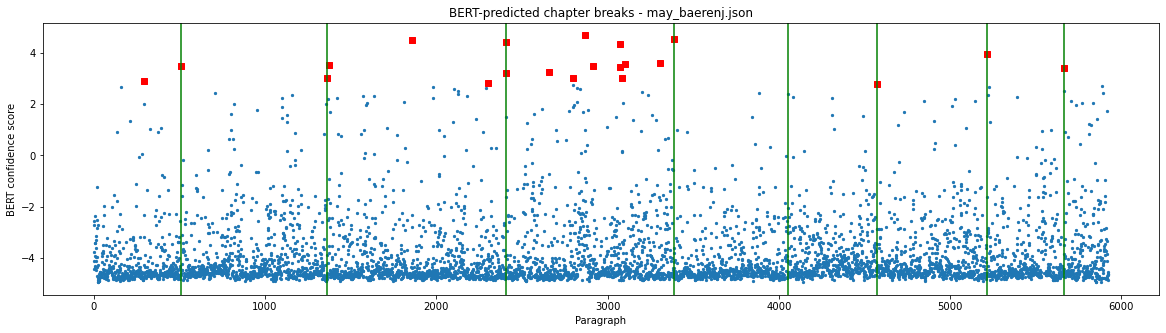

In [ ]:
plot_book(pred_df, "may_baerenj.json", column="confidences_novel_prediction")